# Basic Neural Network

Let’s create your first Neural Network! Building on the Logistic Regression, we are going to implement one hidden layer with a sigmoid activation function. Remember the last layer of the neural network is just a logistic regression layer. We will be using the Digits dataset.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from sklearn import datasets, linear_model,model_selection,metrics, preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
%matplotlib inline

## 1) Load the dataset

In [2]:
from sklearn.datasets import load_digits 
digits = load_digits() #load dataset

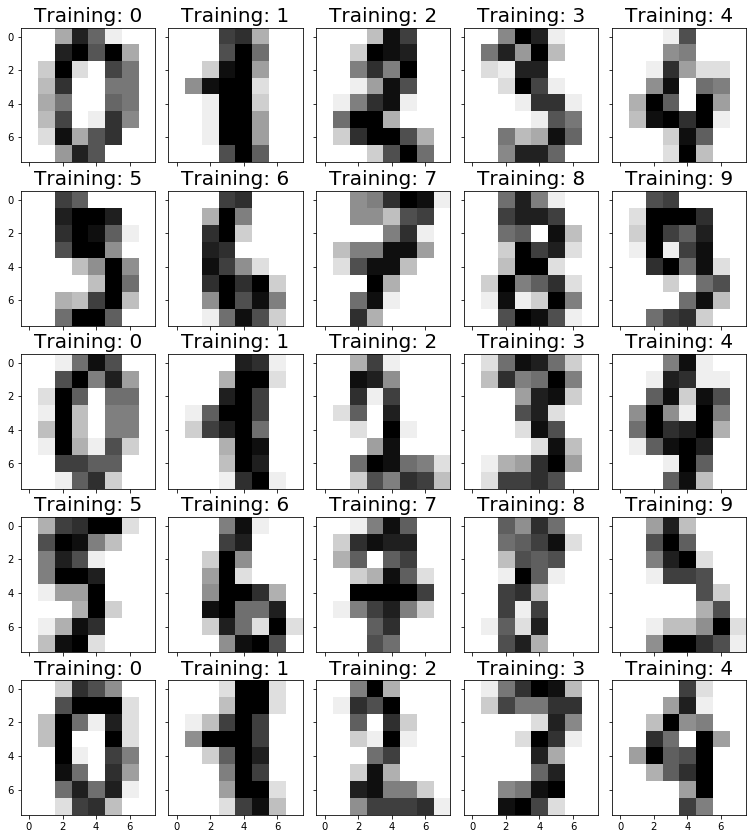

In [3]:
# We visualize the dataset with matplotlib
plt.figure(figsize=(13, 15))
nh, nv = 5,5
gs = gridspec.GridSpec(nv, nh)  
for i, (image, label) in enumerate(zip(digits.data[0:25], digits.target[0:25])):
    ax = plt.subplot(gs[i // nh, i % nh])
    if i % nh != 0:
        ax.set_yticklabels([])
    if i // nh != nv - 1:
        ax.set_xticklabels([])
    ax.set_title('Training: %i' % label, fontsize = 20)
    ax.imshow(digits.images[i], cmap=plt.cm.gray_r, interpolation='nearest')
    gs.update(wspace=0.1000, hspace=0.000)


## 2) Functions
Import the functions from Logistic Regression (one_hot, nll, softmax).

In [4]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

def softmax(X):
    exp = np.exp(X)
    return exp / np.sum(exp, axis=-1, keepdims=True)

EPSILON = 1e-8

def nll(Y_true, Y_pred):
    Y_true, Y_pred = np.atleast_2d(Y_true), np.atleast_2d(Y_pred)
    loglikelihoods = np.sum(np.log(EPSILON + Y_pred) * Y_true, axis=1)
    return -np.mean(loglikelihoods)



## 3) Preprocess the Data
Preprocess data using train test split, scaling and your one hot encoding function.

In [5]:
data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.15, random_state=37)
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
Y_train = one_hot(10, y_train)
Y_test = one_hot(10, y_test)

## 4) Define activation function
Implement the ‘sigmoid’ and its element-wise derivative ‘dsigmoid’ functions

In [6]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def dsigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

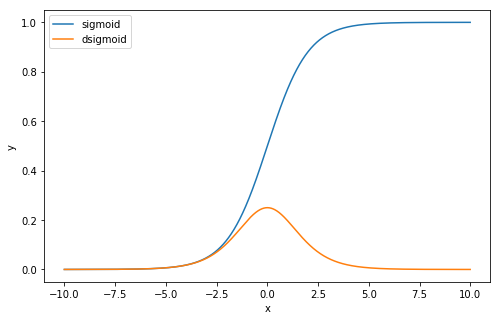

In [7]:
# We plot the sigmoid and dsigmoid functions
plt.figure(figsize=(8, 5))
x_plot=np.arange(-10,10,0.01)
ax = plt.subplot(1,1,1)
ax.plot(x_plot, sigmoid(x_plot), label='sigmoid')
ax.plot(x_plot, dsigmoid(x_plot), label='dsigmoid')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc='best')
None

## 5) Functions for NN
Functions for the Neural Network

In [8]:
# Initial conditions
input_size = X_train.shape[1] 
output_size = Y_train.shape[1] 
hidden_size = 10 
W_h = np.random.uniform(size=(input_size, hidden_size), high=0.01, low=-0.01) 
b_h = np.zeros(hidden_size) 
W_o = np.random.uniform(size=(hidden_size, output_size), high=0.01, low=-0.01) 
b_o = np.zeros(output_size)

Implemented ‘forward’ and ‘forward_keep_activations’ functions (model with a hidden layer)

‘Loss’, ‘predict’ and ‘accuracy’ functions are those for the Logistic Regression.

The ‘grad_loss’ function computes the gradient of sample x with respect to the two W and bs

Created ‘train’ function similar to logistic regression but with W_h, b_h, W_o and b_h.


In [9]:
def forward(X):
    z_h = np.dot(X, W_h) + b_h
    h = sigmoid(z_h)
    z_o = np.dot(h, W_o) + b_o
    y = softmax(z_o)
    return y

def forward_keep_activations (X):
    z_h = np.dot(X, W_h) + b_h
    h = sigmoid(z_h)
    z_o = np.dot(h, W_o) + b_o
    y = softmax(z_o)
    return y,h,z_h    

def loss(x, y):
    # Use `nll` to compute the loss for the sample x with true label y
    return nll(one_hot(output_size, y), forward(x))

def predict(X):
    # For each sample return the predicted class
    if len(X.shape) == 1:
        return np.argmax(forward(X))
    else:
        return np.argmax(forward(X), axis=1)

def accuracy(X, y):
    # Compute accuracy for samples X with true labels y
    y_preds = np.argmax(forward(X), axis=1)
    return np.mean(y_preds == y)


def grad_loss(x, y_true):
    y, h, z_h = forward_keep_activations (x)
    grad_z_o = y - one_hot(output_size, y_true)
    grad_W_o = np.outer(h, grad_z_o)
    grad_b_o = grad_z_o
    grad_h = np.dot(grad_z_o, np.transpose(W_o))
    grad_z_h = grad_h * dsigmoid(z_h)
    grad_W_h = np.outer(x, grad_z_h)
    grad_b_h = grad_z_h
    grads = {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}
    return grads
  
def train(x, y, learning_rate):
    # Traditional gradient descent update without momentum
    global W_h
    global W_o
    global b_h
    global b_o
    grads = grad_loss(x, y)
    W_h = W_h - learning_rate * grads["W_h"]
    W_o = W_o - learning_rate * grads["W_o"]
    b_h = b_h - learning_rate * grads["b_h"]
    b_o = b_o - learning_rate * grads["b_o"] 



## 6. Build and evaluate untrained model
We test the ‘loss’ and ‘train’ functions before training and plot predicted and true probabilities.

In [10]:
print("Evaluation of the untrained model:")
train_loss = loss(X_train, y_train)
train_acc = accuracy(X_train, y_train)
test_acc = accuracy(X_test, y_test)

print("train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
      % (train_loss, train_acc, test_acc))

Evaluation of the untrained model:
train loss: 2.3028, train acc: 0.097, test acc: 0.107


2


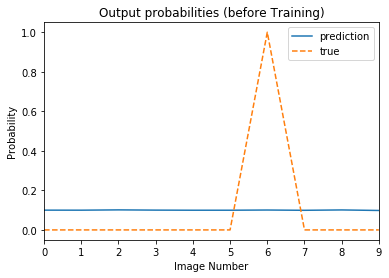

In [11]:
sample_idx = 4
plt.plot(forward(X_train[sample_idx]), linestyle='-', label='prediction')
plt.plot(one_hot(10, y_train[sample_idx]), linestyle='--', label='true')
plt.title('Output probabilities (before Training)')
plt.xlabel('Image Number')
plt.ylabel('Probability')
plt.xlim([0, 9])
plt.legend()
print(np.argmax(forward(X_train[sample_idx])))
None

## 7. Train for 35 epochs
Create loop to train for 35 epochs showing change in train loss, train acc and test acc. Plot graphs for probabilities, training loss and training accuracy.

In [12]:
hidden_size = 10
epochs = 35
learning_rate = 0.01

W_h = np.random.uniform(size=(input_size, hidden_size), high=0.01, low=-0.01)
b_h = np.zeros(hidden_size)
W_o = np.random.uniform(size=(hidden_size, output_size), high=0.01, low=-0.01)
b_o = np.zeros(output_size)


train_loss=np.zeros(epochs+1)
train_acc=np.zeros(epochs+1)
test_acc=np.zeros(epochs+1)

train_loss[0]=loss(X_train, y_train)
train_acc[0]=accuracy(X_train, y_train)
test_acc[0]=accuracy(X_test, y_test)  


for epoch in range(epochs):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        train(x, y, learning_rate)
    idx=epoch+1
    train_loss[idx]=(loss(X_train, y_train))
    train_acc[idx]=(accuracy(X_train, y_train))
    test_acc[idx]=(accuracy(X_test, y_test))   
    print("Epoch #%d, train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
                  % (epoch, train_loss[idx], train_acc[idx], test_acc[idx]))

Epoch #0, train loss: 2.3000, train acc: 0.109, test acc: 0.063
Epoch #1, train loss: 1.9975, train acc: 0.227, test acc: 0.185
Epoch #2, train loss: 1.4842, train acc: 0.676, test acc: 0.626
Epoch #3, train loss: 1.0732, train acc: 0.785, test acc: 0.744
Epoch #4, train loss: 0.8083, train acc: 0.824, test acc: 0.785
Epoch #5, train loss: 0.6391, train acc: 0.853, test acc: 0.822
Epoch #6, train loss: 0.5234, train acc: 0.884, test acc: 0.856
Epoch #7, train loss: 0.4383, train acc: 0.906, test acc: 0.870
Epoch #8, train loss: 0.3731, train acc: 0.926, test acc: 0.893
Epoch #9, train loss: 0.3221, train acc: 0.942, test acc: 0.915
Epoch #10, train loss: 0.2824, train acc: 0.952, test acc: 0.919
Epoch #11, train loss: 0.2514, train acc: 0.957, test acc: 0.933
Epoch #12, train loss: 0.2269, train acc: 0.965, test acc: 0.944
Epoch #13, train loss: 0.2071, train acc: 0.967, test acc: 0.952
Epoch #14, train loss: 0.1908, train acc: 0.971, test acc: 0.952
Epoch #15, train loss: 0.1772, trai

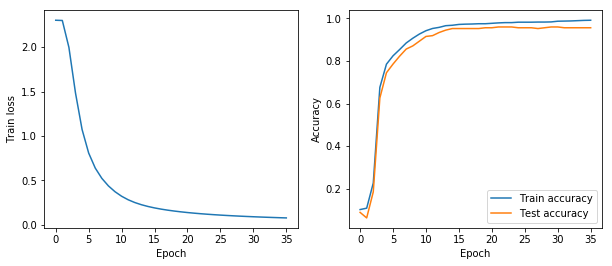

In [13]:
plt.figure(figsize=(10, 4))
x_plot=np.arange(0,36,1)
ax1 = plt.subplot(1,2,1)
ax1.plot(x_plot, train_loss)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train loss')
ax2 = plt.subplot(1,2,2)
ax2.plot(x_plot, train_acc,label='Train accuracy')
ax2.plot(x_plot, test_acc,label='Test accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='best')
None

## 8) Repeat the exercise with... a) Not normalized data

In [14]:
data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# scaler = preprocessing.StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

Y_train = one_hot(10, y_train)
Y_test = one_hot(10, y_test)

# Initial conditions
input_size = X_train.shape[1] 
output_size = Y_train.shape[1] 
hidden_size = 10 
W_h = np.random.uniform(size=(input_size, hidden_size), high=0.01, low=-0.01) 
b_h = np.zeros(hidden_size) 
W_o = np.random.uniform(size=(hidden_size, output_size), high=0.01, low=-0.01) 
b_o = np.zeros(output_size)

hidden_size = 10
epochs = 35
learning_rate = 0.01

W_h = np.random.uniform(size=(input_size, hidden_size), high=0.01, low=-0.01)
b_h = np.zeros(hidden_size)
W_o = np.random.uniform(size=(hidden_size, output_size), high=0.01, low=-0.01)
b_o = np.zeros(output_size)


train_loss=np.zeros(epochs+1)
train_acc=np.zeros(epochs+1)
test_acc=np.zeros(epochs+1)

train_loss[0]=loss(X_train, y_train)
train_acc[0]=accuracy(X_train, y_train)
test_acc[0]=accuracy(X_test, y_test)  


for epoch in range(epochs):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        train(x, y, learning_rate)
    idx=epoch+1
    train_loss[idx]=(loss(X_train, y_train))
    train_acc[idx]=(accuracy(X_train, y_train))
    test_acc[idx]=(accuracy(X_test, y_test))   
    print("Epoch #%d, train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
                  % (epoch, train_loss[idx], train_acc[idx], test_acc[idx]))

Epoch #0, train loss: 1.4824, train acc: 0.565, test acc: 0.507
Epoch #1, train loss: 0.9270, train acc: 0.791, test acc: 0.733
Epoch #2, train loss: 0.7001, train acc: 0.836, test acc: 0.781
Epoch #3, train loss: 0.5336, train acc: 0.910, test acc: 0.870
Epoch #4, train loss: 0.4498, train acc: 0.919, test acc: 0.878
Epoch #5, train loss: 0.3816, train acc: 0.923, test acc: 0.881
Epoch #6, train loss: 0.3307, train acc: 0.935, test acc: 0.900
Epoch #7, train loss: 0.2918, train acc: 0.938, test acc: 0.907
Epoch #8, train loss: 0.3108, train acc: 0.928, test acc: 0.904
Epoch #9, train loss: 0.2550, train acc: 0.943, test acc: 0.911
Epoch #10, train loss: 0.2508, train acc: 0.945, test acc: 0.911
Epoch #11, train loss: 0.2090, train acc: 0.958, test acc: 0.919
Epoch #12, train loss: 0.2278, train acc: 0.950, test acc: 0.915
Epoch #13, train loss: 0.2106, train acc: 0.955, test acc: 0.930
Epoch #14, train loss: 0.2001, train acc: 0.959, test acc: 0.911
Epoch #15, train loss: 0.1801, trai

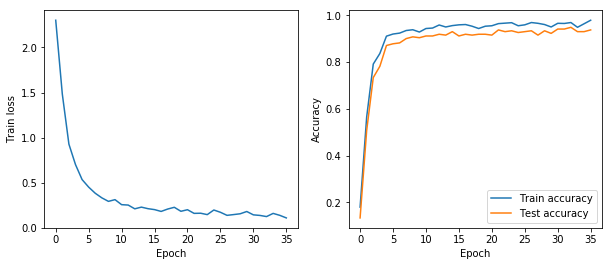

In [15]:
plt.figure(figsize=(10, 4))
x_plot=np.arange(0,36,1)
ax = plt.subplot(1,2,1)
ax.plot(x_plot, train_loss)
ax.set_xlabel('Epoch')
ax.set_ylabel('Train loss')
ax = plt.subplot(1,2,2)
ax.plot(x_plot, train_acc,label='Train accuracy')
ax.plot(x_plot, test_acc,label='Test accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(loc='best')
None

## 8 b) Different learning rates

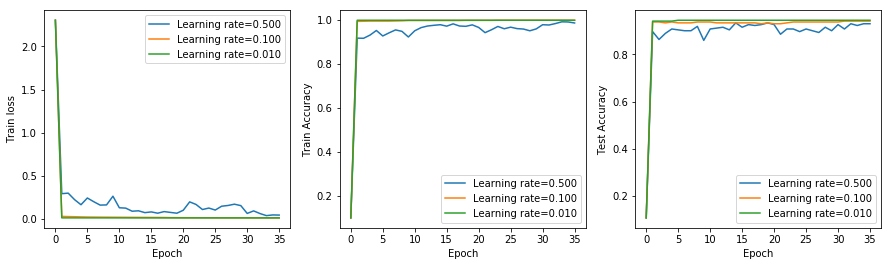

In [16]:
data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Y_train = one_hot(10, y_train)
Y_test = one_hot(10, y_test)

# Initial conditions
input_size = X_train.shape[1] 
output_size = Y_train.shape[1] 
hidden_size = 10 
W_h = np.random.uniform(size=(input_size, hidden_size), high=0.01, low=-0.01) 
b_h = np.zeros(hidden_size) 
W_o = np.random.uniform(size=(hidden_size, output_size), high=0.01, low=-0.01) 
b_o = np.zeros(output_size)

hidden_size = 10
epochs = 35

W_h = np.random.uniform(size=(input_size, hidden_size), high=0.01, low=-0.01)
b_h = np.zeros(hidden_size)
W_o = np.random.uniform(size=(hidden_size, output_size), high=0.01, low=-0.01)
b_o = np.zeros(output_size)


train_loss=np.zeros(epochs+1)
train_acc=np.zeros(epochs+1)
test_acc=np.zeros(epochs+1)

train_loss[0]=loss(X_train, y_train)
train_acc[0]=accuracy(X_train, y_train)
test_acc[0]=accuracy(X_test, y_test)  


learning_rate = 0.5
for epoch in range(epochs):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        train(x, y, learning_rate)
    idx=epoch+1
    train_loss[idx]=(loss(X_train, y_train))
    train_acc[idx]=(accuracy(X_train, y_train))
    test_acc[idx]=(accuracy(X_test, y_test))   
#     print("Epoch #%d,%d train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
#                   % (epoch,idx, train_loss[idx], train_acc[idx], test_acc[idx]))
   
plt.figure(figsize=(15, 4))
x_plot=np.arange(0,36,1)
ax1 = plt.subplot(1,3,1)
ax1.plot(x_plot, train_loss,label='Learning rate=%0.3f'%learning_rate)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train loss')
ax2 = plt.subplot(1,3,2)
ax2.plot(x_plot, train_acc,label='Learning rate=%0.3f'%learning_rate)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Train Accuracy')
ax3 = plt.subplot(1,3,3)
ax3.plot(x_plot, test_acc,label='Learning rate=%0.3f'%learning_rate)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Test Accuracy')


learning_rate = 0.1
for epoch in range(epochs):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        train(x, y, learning_rate)
    idx=epoch+1
    train_loss[idx]=(loss(X_train, y_train))
    train_acc[idx]=(accuracy(X_train, y_train))
    test_acc[idx]=(accuracy(X_test, y_test))   
#     print("Epoch #%d,%d train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
#                   % (epoch,idx, train_loss[idx], train_acc[idx], test_acc[idx]))
   

ax1.plot(x_plot, train_loss,label='Learning rate=%0.3f'%learning_rate)
ax2.plot(x_plot, train_acc,label='Learning rate=%0.3f'%learning_rate)
ax3.plot(x_plot, test_acc,label='Learning rate=%0.3f'%learning_rate)


learning_rate = 0.01
for epoch in range(epochs):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        train(x, y, learning_rate)
    idx=epoch+1
    train_loss[idx]=(loss(X_train, y_train))
    train_acc[idx]=(accuracy(X_train, y_train))
    test_acc[idx]=(accuracy(X_test, y_test))   
#     print("Epoch #%d,%d train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
#                   % (epoch,idx, train_loss[idx], train_acc[idx], test_acc[idx]))
   
ax1.plot(x_plot, train_loss,label='Learning rate=%0.3f'%learning_rate)
ax2.plot(x_plot, train_acc,label='Learning rate=%0.3f'%learning_rate)
ax3.plot(x_plot, test_acc,label='Learning rate=%0.3f'%learning_rate)
ax1.legend(loc='best')
ax2.legend(loc='best')
ax3.legend(loc='best')
None



## 8.c) Size of the hidden layer

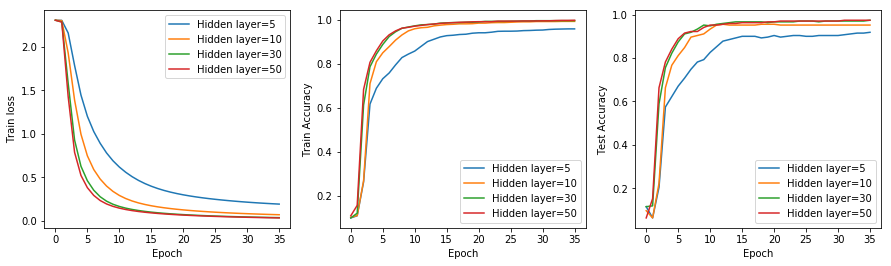

In [17]:
data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Y_train = one_hot(10, y_train)
Y_test = one_hot(10, y_test)

# Initial conditions
input_size = X_train.shape[1] 
output_size = Y_train.shape[1] 
hidden_size = 10 
W_h = np.random.uniform(size=(input_size, hidden_size), high=0.01, low=-0.01) 
b_h = np.zeros(hidden_size) 
W_o = np.random.uniform(size=(hidden_size, output_size), high=0.01, low=-0.01) 
b_o = np.zeros(output_size)

hidden_size = 5
epochs = 35
learning_rate = 0.01


W_h = np.random.uniform(size=(input_size, hidden_size), high=0.01, low=-0.01)
b_h = np.zeros(hidden_size)
W_o = np.random.uniform(size=(hidden_size, output_size), high=0.01, low=-0.01)
b_o = np.zeros(output_size)


train_loss=np.zeros(epochs+1)
train_acc=np.zeros(epochs+1)
test_acc=np.zeros(epochs+1)

train_loss[0]=loss(X_train, y_train)
train_acc[0]=accuracy(X_train, y_train)
test_acc[0]=accuracy(X_test, y_test)  


for epoch in range(epochs):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        train(x, y, learning_rate)
    idx=epoch+1
    train_loss[idx]=(loss(X_train, y_train))
    train_acc[idx]=(accuracy(X_train, y_train))
    test_acc[idx]=(accuracy(X_test, y_test))   
#     print("Epoch #%d,%d train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
#                   % (epoch,idx, train_loss[idx], train_acc[idx], test_acc[idx]))
   
plt.figure(figsize=(15, 4))
x_plot=np.arange(0,36,1)
ax1 = plt.subplot(1,3,1)
ax1.plot(x_plot, train_loss,label='Hidden layer=%0.f'%hidden_size)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train loss')
ax2 = plt.subplot(1,3,2)
ax2.plot(x_plot, train_acc,label='Hidden layer=%0.f'%hidden_size)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Train Accuracy')
ax3 = plt.subplot(1,3,3)
ax3.plot(x_plot, test_acc,label='Hidden layer=%0.f'%hidden_size)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Test Accuracy')

hidden_size = 10
epochs = 35
learning_rate = 0.01


W_h = np.random.uniform(size=(input_size, hidden_size), high=0.01, low=-0.01)
b_h = np.zeros(hidden_size)
W_o = np.random.uniform(size=(hidden_size, output_size), high=0.01, low=-0.01)
b_o = np.zeros(output_size)


train_loss=np.zeros(epochs+1)
train_acc=np.zeros(epochs+1)
test_acc=np.zeros(epochs+1)

train_loss[0]=loss(X_train, y_train)
train_acc[0]=accuracy(X_train, y_train)
test_acc[0]=accuracy(X_test, y_test)  



for epoch in range(epochs):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        train(x, y, learning_rate)
    idx=epoch+1
    train_loss[idx]=(loss(X_train, y_train))
    train_acc[idx]=(accuracy(X_train, y_train))
    test_acc[idx]=(accuracy(X_test, y_test))   
#     print("Epoch #%d,%d train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
#                   % (epoch,idx, train_loss[idx], train_acc[idx], test_acc[idx]))
   

ax1.plot(x_plot, train_loss,label='Hidden layer=%0.f'%hidden_size)
ax2.plot(x_plot, train_acc,label='Hidden layer=%0.f'%hidden_size)
ax3.plot(x_plot, test_acc,label='Hidden layer=%0.f'%hidden_size)



hidden_size = 30
epochs = 35
learning_rate = 0.01


W_h = np.random.uniform(size=(input_size, hidden_size), high=0.01, low=-0.01)
b_h = np.zeros(hidden_size)
W_o = np.random.uniform(size=(hidden_size, output_size), high=0.01, low=-0.01)
b_o = np.zeros(output_size)


train_loss=np.zeros(epochs+1)
train_acc=np.zeros(epochs+1)
test_acc=np.zeros(epochs+1)

train_loss[0]=loss(X_train, y_train)
train_acc[0]=accuracy(X_train, y_train)
test_acc[0]=accuracy(X_test, y_test)  



for epoch in range(epochs):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        train(x, y, learning_rate)
    idx=epoch+1
    train_loss[idx]=(loss(X_train, y_train))
    train_acc[idx]=(accuracy(X_train, y_train))
    test_acc[idx]=(accuracy(X_test, y_test))   
#     print("Epoch #%d,%d train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
#                   % (epoch,idx, train_loss[idx], train_acc[idx], test_acc[idx]))
   

ax1.plot(x_plot, train_loss,label='Hidden layer=%0.f'%hidden_size)
ax2.plot(x_plot, train_acc,label='Hidden layer=%0.f'%hidden_size)
ax3.plot(x_plot, test_acc,label='Hidden layer=%0.f'%hidden_size)




hidden_size = 50
epochs = 35
learning_rate = 0.01


W_h = np.random.uniform(size=(input_size, hidden_size), high=0.01, low=-0.01)
b_h = np.zeros(hidden_size)
W_o = np.random.uniform(size=(hidden_size, output_size), high=0.01, low=-0.01)
b_o = np.zeros(output_size)


train_loss=np.zeros(epochs+1)
train_acc=np.zeros(epochs+1)
test_acc=np.zeros(epochs+1)

train_loss[0]=loss(X_train, y_train)
train_acc[0]=accuracy(X_train, y_train)
test_acc[0]=accuracy(X_test, y_test)  



for epoch in range(epochs):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        train(x, y, learning_rate)
    idx=epoch+1
    train_loss[idx]=(loss(X_train, y_train))
    train_acc[idx]=(accuracy(X_train, y_train))
    test_acc[idx]=(accuracy(X_test, y_test))   
#     print("Epoch #%d,%d train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
#                   % (epoch,idx, train_loss[idx], train_acc[idx], test_acc[idx]))
   
ax1.plot(x_plot, train_loss,label='Hidden layer=%0.f'%hidden_size)
ax2.plot(x_plot, train_acc,label='Hidden layer=%0.f'%hidden_size)
ax3.plot(x_plot, test_acc,label='Hidden layer=%0.f'%hidden_size)

ax1.legend(loc='best')
ax2.legend(loc='best')
ax3.legend(loc='best')
None


## 8.d) Epochs

CPU times: user 1min 16s, sys: 871 ms, total: 1min 16s
Wall time: 38.7 s


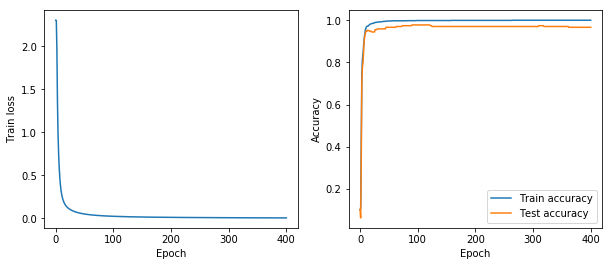

In [18]:
%%time
data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Y_train = one_hot(10, y_train)
Y_test = one_hot(10, y_test)

# Initial conditions
input_size = X_train.shape[1] 
output_size = Y_train.shape[1] 
hidden_size = 10 
W_h = np.random.uniform(size=(input_size, hidden_size), high=0.01, low=-0.01) 
b_h = np.zeros(hidden_size) 
W_o = np.random.uniform(size=(hidden_size, output_size), high=0.01, low=-0.01) 
b_o = np.zeros(output_size)

hidden_size = 10
epochs = 400
learning_rate = 0.01

W_h = np.random.uniform(size=(input_size, hidden_size), high=0.01, low=-0.01)
b_h = np.zeros(hidden_size)
W_o = np.random.uniform(size=(hidden_size, output_size), high=0.01, low=-0.01)
b_o = np.zeros(output_size)


train_loss=np.zeros(epochs+1)
train_acc=np.zeros(epochs+1)
test_acc=np.zeros(epochs+1)

train_loss[0]=loss(X_train, y_train)
train_acc[0]=accuracy(X_train, y_train)
test_acc[0]=accuracy(X_test, y_test)  


for epoch in range(epochs):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        train(x, y, learning_rate)
    idx=epoch+1
    train_loss[idx]=(loss(X_train, y_train))
    train_acc[idx]=(accuracy(X_train, y_train))
    test_acc[idx]=(accuracy(X_test, y_test))   
    
plt.figure(figsize=(10, 4))
x_plot=np.arange(0,epochs+1,1)
ax = plt.subplot(1,2,1)
ax.plot(x_plot, train_loss)
ax.set_xlabel('Epoch')
ax.set_ylabel('Train loss')
ax = plt.subplot(1,2,2)
ax.plot(x_plot, train_acc,label='Train accuracy')
ax.plot(x_plot, test_acc,label='Test accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(loc='best')
None    

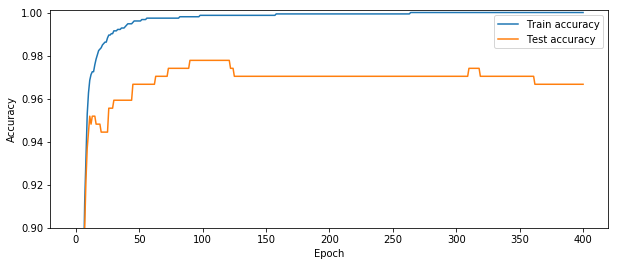

In [19]:
plt.figure(figsize=(10, 4))
x_plot=np.arange(0,epochs+1,1)
ax = plt.subplot(111)
ax.plot(x_plot, train_acc,label='Train accuracy')
ax.plot(x_plot, test_acc,label='Test accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.90,1.001)
ax.legend(loc='best')
None 